In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 462 kB 48.9 MB/s 


In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 24.5 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 237 kB 45.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
     |████████████████████████████████| 352 kB 40.5 MB/s 
     |████████████████████████████████| 1.1 MB 38.8 MB/s 
     |████████████████████████████████| 43 kB 755 kB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
import pandas as pd
ladec = pd.read_csv('/content/drive/MyDrive/all_embeddings_forML.csv')
c1, c2, cmp = ladec['c1'].to_list(), ladec['c2'].to_list(), ladec['cmp'].to_list()

In [ ]:
kept_words = list(zip(c1, c2, cmp))

In [ ]:
split = 5000

glue_dict = {
    "training": {
        "sentence1": [w[0] for w in kept_words[:split]],
        "sentence2": [w[1] for w in kept_words[:split]],
        "compounds": [w[2] for w in kept_words[:split]],
        "label":      tf.convert_to_tensor([i for i in range(split)])
    },
    "validation": {
        "sentence1": [w[0] for w in kept_words[split:]],
        "sentence2": [w[1] for w in kept_words[split:]],
        "compounds": [w[2] for w in kept_words[split:]],
        "label":      tf.convert_to_tensor([i for i in range(split, len(kept_words))])
    }
}

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

  return {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
  }

In [ ]:
glue_train = bert_encode(glue_dict["training"], tokenizer)
glue_validation = bert_encode(glue_dict["validation"], tokenizer)

In [ ]:
import json
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=len(kept_words))

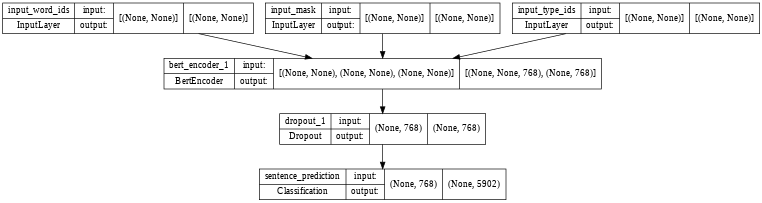

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_dict["training"]["label"])
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_dict["training"]["label"],
      validation_data=(glue_validation, glue_dict["validation"]["label"]),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
157/157 [==============================] - 690s 4s/step - loss: 8.7068 - accuracy: 2.0000e-04 - val_loss: 8.6944 - val_accuracy: 0.0000e+00
Epoch 2/3
157/157 [==============================] - 666s 4s/step - loss: 8.6907 - accuracy: 0.0000e+00 - val_loss: 8.7780 - val_accuracy: 0.0000e+00
Epoch 3/3
157/157 [==============================] - 664s 4s/step - loss: 8.6592 - accuracy: 4.0000e-04 - val_loss: 8.8399 - val_accuracy: 0.0000e+00


In [24]:
my_examples = bert_encode({'sentence1':['rail'], 'sentence2':['road']}, tokenizer=tokenizer)

In [25]:
result = bert_classifier(my_examples, training=False)
result = tf.argmax(result, axis=1).numpy()[0]
kept_words[result]

('seed', 'bed', 'seedbed')